In [4]:
from binance.client import Client
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import numpy as np
import talib

In [3]:
api_key = "8AiGAyxlhYQaRpE1s7097hx5sZ12Ogtr8ir9DsyztaD5j24LrI0fEoToDzCI5lle"
api_secret = "VhudTs0HsBVFNdSTghmqfCjUuIXF6rFiXIfROxHIaM71TGgib7NeZ5aOsJUHjI9f"

In [6]:
client = Client(api_key=api_key, api_secret=api_secret)

In [8]:
def get_history(symbol, interval, start=None, end=None):
    if not start:
        start = "1900-01-01"  # Just random old time for maximum candles
    bars = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start, end_str=end, limit=1000)
    
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit="ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number Of Trades", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace=True)

    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")
    return df

In [10]:
def update_btcfile(interval="1m"):
    df = get_history("BTCUSDT", interval, "10-01-01")
    df.to_csv("test_min111.csv")
#     df = pd.read_csv("test.csv", parse_dates=["Date"], index_col="Date")
update_btcfile()

In [74]:
class strategy_tester():
    def __init__(self, filepath, units=1, tc=100):
        self.filepath = filepath
        self.units = units
        self.tc = tc

    def get_data(self):
        self.data = pd.read_csv(self.filepath, parse_dates=["Date"], index_col="Date").loc["2017"]
        
    def prepare_data(self, sma1, sma2):
        df = self.data.copy()
        df["returns"] = np.log(df.Close.div(df.Close.shift(1)))
        df["sma1"] = df.Close.rolling(sma1).mean()
        df["sma2"] = df.Close.rolling(sma2).mean()
#         df["rsi"] = talib.RSI(df.Close, 14)
#         condition = (df.sma1 > df.sma2) & (df.rsi < rsi)
        condition = df.sma1 > df.sma2
    
        df["position"] = 0
        df.loc[condition, "position"] = 1
    
        self.data = df
    
    def run_backtest(self):
        df = self.data.copy()
        df["strategy"] = df.returns * df.position.shift(1)
        df["trades"] = df.position.diff().fillna(0).abs()  # To calculate fees and shit
        df.strategy = df.strategy + (df.trades * self.tc)  # Calculate fees and shit
        df["creturns"] = df.returns.cumsum().apply(np.exp)
        df["cstrategy"] = df.strategy.cumsum().apply(np.exp)
        self.data = df.copy()
        
    def test_strategy(self, sma1, sma2):
        self.get_data()
        df = self.data
        self.prepare_data(sma1, sma2)
        self.run_backtest()
        
    def optimize_strategy(self, sma1r, sma2r):
        self.datas = []
        performance = []
        combinations = list(product(sma1r, sma2r))
        for comb in combinations:
            self.test_strategy(comb[0], comb[1])
#             self.datas.append(self.data)
            performance.append(self.calc_creturn(self.data))
        self.results_overview =  pd.DataFrame(data=np.array(combinations), columns=["sma1", "sma2"])
        self.results_overview["cstrategy"] = performance
        
    def calc_creturn(self, series):
        return float(series[["strategy"]].sum().apply(np.exp))
    
    def get_trades(self):
        df = self.data
        self.trades = pd.DataFrame(index=df.index)
        df["trades2"] = df.poisiton.diff()
        df[df.trades2 != 0.0]
        df["open_trade"]
        

In [69]:
df = pd.read_csv("test_min.csv", parse_dates=["Date"], index_col="Date").loc["2022"]
df

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894
2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029
...,...,...,...,...,...
2022-11-19 16:18:00,16653.34,16654.02,16649.33,16650.50,51.25933
2022-11-19 16:19:00,16650.57,16655.09,16650.22,16652.68,51.11322
2022-11-19 16:20:00,16652.35,16653.75,16651.26,16651.26,21.10588


In [75]:
tester = strategy_tester("test_min.csv", tc=0)

In [45]:
tester.optimize_strategy(range(5, 20), range(12, 35))

In [76]:
tester.test_strategy(7 ,20)

<AxesSubplot: xlabel='Date'>

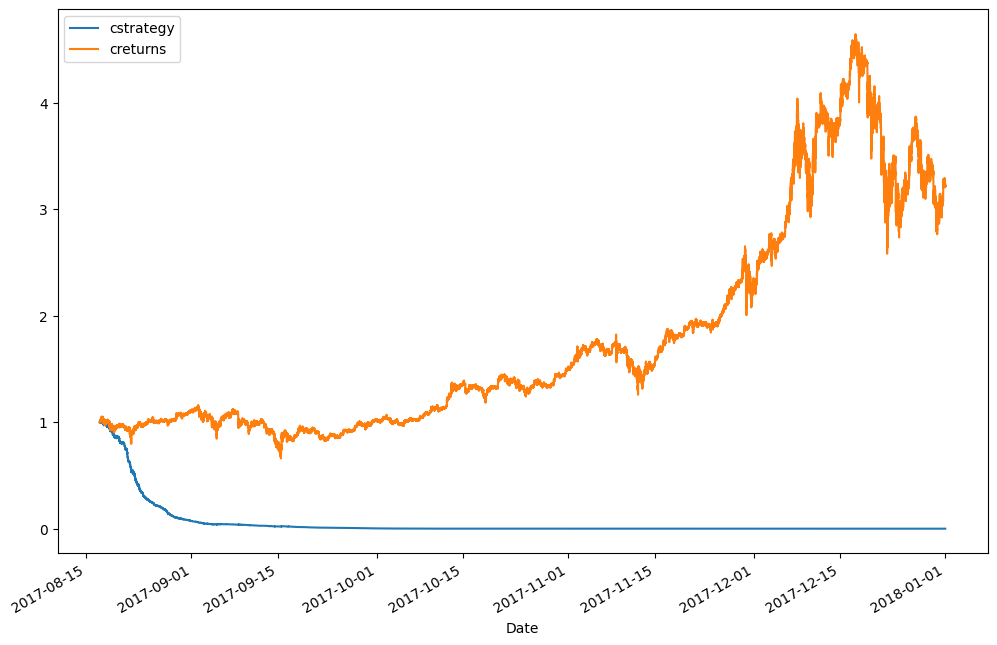

In [77]:
tester.data[["cstrategy", "creturns"]].plot(figsize=(12, 8))

In [78]:
tester.data[["returns", "strategy"]].sum().apply(np.exp)

returns     3.218685
strategy    0.001077
dtype: float64

In [46]:
tester.results_overview.nlargest(10, "cstrategy")

,sma1,sma2,cstrategy
207,14,12,2.654086e+06
230,15,12,2.360706e+06
184,13,12,1.108499e+06
231,15,13,8.834512e+05
208,14,13,5.277037e+05
253,16,12,4.911402e+05
232,15,14,2.995049e+05
276,17,12,1.795064e+05
254,16,13,1.500280e+05
255,16,14,9.558292e+04


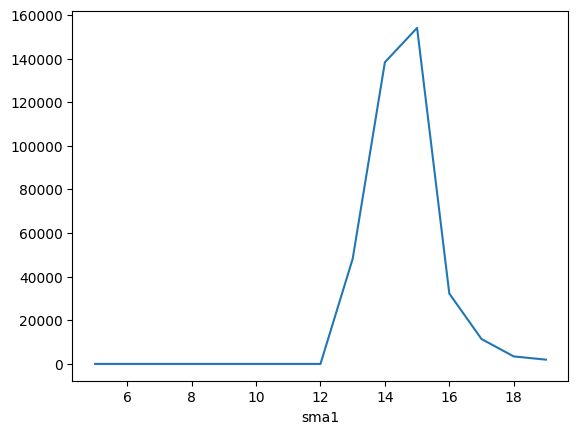

In [47]:
tester.results_overview.groupby("sma1").cstrategy.mean().plot()
plt.show()

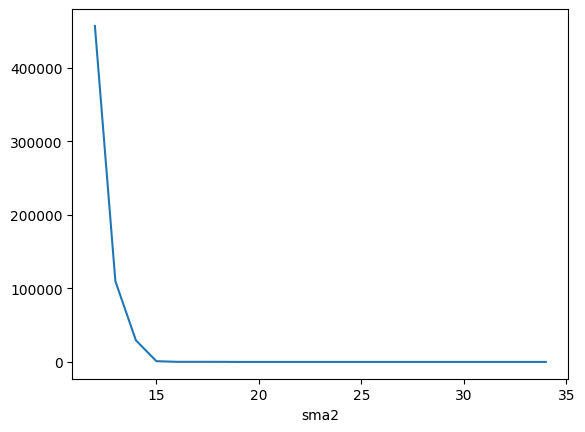

In [48]:
tester.results_overview.groupby("sma2").cstrategy.mean().plot()
plt.show()

In [98]:
tester.data["trades2"] = tester.data.position.diff()
tester.data[tester.data.trades2 != 0.0]

,Open,High,Low,Close,Volume,returns,sma1,sma2,position,strategy,trades,creturns,cstrategy,trades2
Date,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN
2017-08-17 04:21:00,4264.88,4266.29,4264.88,4266.29,0.845556,0.000331,4263.624286,4263.1845,1,0.000000,1.0,1.001129,1.000000,1.0
2017-08-17 05:00:00,4308.83,4308.83,4308.83,4308.83,0.000000,0.000000,4307.698571,4307.8985,0,0.000000,1.0,1.011111,1.009971,-1.0
2017-08-17 05:02:00,4308.83,4308.83,4308.83,4308.83,0.000000,0.000000,4309.511429,4308.7435,1,0.000000,1.0,1.011111,1.009971,1.0
2017-08-17 05:04:00,4308.83,4308.83,4304.31,4304.31,0.129580,-0.001050,4308.184286,4308.3935,0,-0.001050,1.0,1.010050,1.008912,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 22:13:00,13920.12,13944.30,13904.00,13905.57,8.838212,-0.001046,13949.200000,13953.5975,0,-0.001046,1.0,3.263085,0.001079,-1.0
2017-12-31 22:33:00,13889.65,13978.98,13889.65,13923.98,12.924062,0.002468,13901.580000,13901.4605,1,0.000000,1.0,3.267405,0.001079,1.0
2017-12-31 22:43:00,13878.07,13900.00,13875.33,13899.77,0.522332,0.001915,13910.231429,13910.4315,0,0.001915,1.0,3.261724,0.001077,-1.0
